In [ ]:
import numpy as np
import numpy as np
import numba
import matplotlib.pyplot as plt

# If you do not use Google colab, comment out the following import
from google.colab import files

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apache2 | lighttpd | httpd poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arph

#Parameters

In [ ]:
N = 3 # Single unit or 3 unit (N=3)

dt = 0.1 # ms 0.1ms is reasonable
duration = 3500  # Simulation duration (ms)
seed = 0  # seed for RNG of noise and ICs
T = duration
t = np.arange(0,T,dt)

# neural mass model parameters
tau_u = 10   # excitatory time constant
tau_p = 10   # PV time constant
tau_s = 10   # SST time constant
tau_d1 = 1500 # replenishment time constant
tau_d2 = 20   # depletion time constant
t0 = 300
dur = 100
isi = 300

w_ee = 1.1 # local E-E coupling
w_ep = 2.  # local E-PV coupling
w_es = 1.  # local E-SST coupling
w_pe = 1.  # local PV-E coupling
w_pp = 2.  # local PV-PV coupling
w_ps = 2.  # local PV-SST coupling
w_se = 6.  # local SST-E coupling
w_sp = 0.  # local SST-PV coupling
w_ss = 0.  # local SST-SST coupling

w_ee2 = 0.667 # lateral E-E coupling
w_pe2 = 1.25 # lateral PV-E coupling
w_se2 = 0.125 # lateral SST-E coupling
a = 0.5 # degree of depression
b = 2 # degree of facilitation
α = 0.65 # percentage of thalamic input
    

r_u = 3.  # excitatory gain
r_p = 3.  # PV gain
r_s = 3.  # SST gain
u_th = 0.7 # excitatory firing threshold
p_th = 1.0  # PV firing threshold
s_th = 1.0  # SST firing threshold
#q = 5/1.3 # input amplitude

opt_pv_val  = -4 # -4 default Park&Geffen # optogenetic PV suppression variable
opt_sst_val = -2 # optogenetic SST suppression variable


g = np.ones((N, len(t))) # depressing term, g = D for three unit model
F = np.zeros((N, len(t))) # facilitating term F = 1-g for three unit model

I_ext = np.zeros((N, len(t))) #Input   
I = np.zeros((N, len(t))) #Thalamic adapted input I_ext * g


# Functions for input and optogenetic stimulation

In [ ]:
def external_input(t,dt,input_time,dur):
    I_t = np.zeros(len(t))
    for i in range(len(t)):
        for j in range(len(input_time)):
            if t[i]==input_time[j] and t[i]<=input_time[j]+dur:
                I_t[i] =1
    return I_t

def thalamic_input(t, dt, input_time, dur, tau_q = 10, q = 1):
    I_t = np.zeros(len(t))
    for i in range(1,len(t)):
        I_t[i] = I_t[i-1] + (dt/tau_q) * (-I_t[i-1])
        for j in range(len(input_time)):
            if t[i]==input_time[j] and t[i]<=input_time[j]+dur:
                I_t[i] =q
    return I_t

def I_opto(t,laser_on_times,val=-1):
    I_opto = np.zeros((len(t)))
    laser_on_times = np.asarray(laser_on_times)*10
    for i in range(len(laser_on_times)):
        I_opto[laser_on_times[i][0]:laser_on_times[i][1]] = val
    return I_opto


In [ ]:
t = np.arange(0,T,dt)
I_ext = np.zeros((N, len(t))) #Input
I_ext_flipped = np.zeros((N, len(t))) #Input   
I = np.zeros((N, len(t))) #Thalamic adapted input I_ext * g
g = np.ones((N, len(t))) # depressing term, g = D for three unit model
F = np.zeros((N, len(t))) # facilitating term F = 1-g for three unit model
q = 5
dur = 100
input_tones = [200,600,1000,1400,1800,2200,2600,3000]
deviant_tones = [1800]
standard_tones = [200,600,1000,1400,2200,2600,3000]

I_ext[0] = thalamic_input(t, dt, deviant_tones, 100, tau_q = 10, q = 1) #Deviant
I_ext[2]= thalamic_input(t, dt, standard_tones, dur, tau_q = 10, q = 1) #Standard

I_ext_flipped[2] = thalamic_input(t, dt, deviant_tones, 100, tau_q = 10, q = 1) #Deviant
I_ext_flipped[0]= thalamic_input(t, dt, standard_tones, dur, tau_q = 10, q = 1) #Standard

# Helper functions

In [ ]:
#Rectifying 
def f(x, r):
    if x<=0:
        return 0
    elif x<=1/r:
        return r*x
    else:
        return 1
    
#Finding maximum values in firing rates
def find_max(fir_rate,input_tones,dt,interval): 
    max_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            max_values[r][i] = np.max(fir_rate[r][start:end])
        #max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return max_values

#Calculating mean firing rates for the bins
def calc_mean(fir_rate,input_tones,dt,interval):
    mean_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            mean_values[r][i] = np.mean(fir_rate[r][start:end])
            #max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return mean_values


# Three Unit Model

In [ ]:
def three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,Iopt_PV,Iopt_SST,opt_gen_flag=0):
    u = np.zeros((N,len(t)))
    p = np.zeros((N,len(t)))
    s = np.zeros((N,len(t)))
    g = np.ones((N,len(t)))
    F = np.zeros((N,len(t)))
    J1 = np.zeros((N,len(t)))
    J2 = np.zeros((N,len(t)))
    J3 = np.zeros((N,len(t)))
    
    for ti in range(1,len(t)): 
        for i in range(N):
            g[i,ti] = g[i,ti-1] + dt* (((1-g[i,ti-1])/tau_d1)-((g[i,ti-1] * I_ext[i,ti-1])/tau_d2))
            F[i,ti] = F[i,ti-1] + dt * (((- F[i,ti-1]) / tau_d1)+((I_ext[i,ti-1]) / tau_d2))
        
            if i == 0 or i ==2:
                I[i][ti-1]  = g[i][ti-1]*I_ext[i][ti-1] + (α * g[1][ti-1]*I_ext[1][ti-1])
                J1[i][ti-1] = -F[i][ti-1]*s[1][ti-1] + q*I[i][ti-1]+w_ee2*u[1][ti-1]
                J2[i][ti-1] = q*I[i][ti-1] +w_pe2*u[1][ti-1]
                J3[i][ti-1] = w_se2*u[1][ti-1]
            elif i ==1:
                I[1][ti-1]  = g[1][ti-1]*I_ext[i][ti-1] + (α *(g[0][ti-1]*I_ext[0][ti-1] + g[2][ti-1]*I_ext[2][ti-1]))
                J1[1][ti-1] = -F[1][ti-1]*(s[0][ti-1]+s[2][ti-1]) + q*I[1][ti-1]+(w_ee2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                J2[1][ti-1] =  q*I[1][ti-1] + (w_pe2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                J3[1][ti-1] =  (w_se2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                
            u[i][ti] = u[i][ti-1] + (dt/tau_u) * (-u[i][ti-1] + f(w_ee * u[i][ti-1] -(w_ep-a *(1-g[i][ti-1]))*p[i][ti-1] -w_es*s[i][ti-1] +J1[i][ti-1]-u_th,r_u))
            p[i][ti] = p[i][ti-1] + (dt/tau_p) * (-p[i][ti-1] + f(w_pe * u[i][ti-1] -w_pp*p[i][ti-1] -w_ps*s[i][ti-1] + Iopt_PV[ti-1] + J2[i][ti-1]-p_th,r_p))
            s[i][ti] = s[i][ti-1] + (dt/tau_s) * (-s[i][ti-1] + f(w_se * u[i][ti-1] -w_sp*p[i][ti-1] -w_ss*s[i][ti-1] + Iopt_SST[ti-1] + J3[i][ti-1]-s_th,r_s))
    return g,u,p,s   

# Optogenetic Input

In [ ]:
laser_on_times =[]
for i in range(len(input_tones)):
    laser_on_times.append([input_tones[i]-100,input_tones[i]+50])

 

# Simulations

Simulations for Figure 5A

In [ ]:
w_ees = np.arange(0,2,step=.05)
opt_pv_vals = np.arange(-5,1.5,step=.1)
print(len(w_ees))
print(len(opt_pv_vals))

csi = np.zeros((len(w_ees),len(opt_pv_vals)))

for i,w in enumerate(w_ees):
  print(i)
  for j,o in enumerate(opt_pv_vals):
    #print(j)
    w_ee = w
    #PV Off
    opt_pv = I_opto(t,laser_on_times,val=o)
    opt_sst = np.zeros((len(t)))
    opt_gen_flag = 1
    pv_g,pv_u,pv_p,pv_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
    pv_g_flipped,pv_u_flipped,pv_p_flipped,pv_s_flipped = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext_flipped,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

    max = find_max([pv_u[1]],input_tones,dt,200)
    max_flipped = find_max([pv_u_flipped[1]],input_tones,dt,200)
    d1 = max[0][4]
    d2 = max_flipped[0][4]
    s1 = max[0][7]
    s2 = max_flipped[0][7]
    csi[i,j] = (d1+d2-s1-s2)/(d1+d2+s1+s2)
np.save('Fig5-A-data.npy', csi)
files.download('Fig5-A-data.npy')

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
2
0
2
1
2
2
2
3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25
2
26
2
27
2
28
2
29
2
30
2
31
2
32
2
33
2
34
2
35
2
36
2
37
2
38
2
39
2
40
2
41
2
42
2
43
2
44
2
45
2
46
2
47
2
48
2
49
2
50
2
51
2
52
2
53
2
54
2
55
2
56
2
57
2
58
2
59
2
60
2
61
2
62
2
63
2
64
3
0
3
1
3
2
3
3
3
4
3
5
3
6
3
7
3
8
3
9
3
10
3
11
3
12
3
13
3
14
3
15
3
16
3
17
3
18
3
19
3
20
3
21
3
22
3
23
3
24
3
25
3
26
3
27
3
28
3
29
3
30
3
31
3
32
3
33
3
34
3
35
3
36
3
37
3
38
3
39
3
40
3
41
3
42
3
43
3
44
3
45
3
46
3
47
3
48
3
49
3
50
3
51
3
52
3
53
3
54
3
55
3
56
3
57
3
58
3
59
3
60
3
61
3
62
3
63
3
64
4
0
4
1
4
2
4
3
4
4
4
5
4
6
4
7
4
8
4
9
4
10
4
11
4
12
4
13
4
14
4
15
4
16
4
17
4
18
4
19
4
20
4
21
4
22
4
23
4
24
4
25
4
26
4
27
4
28
4
29
4
30
4
31
4
3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot Fig 5 A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

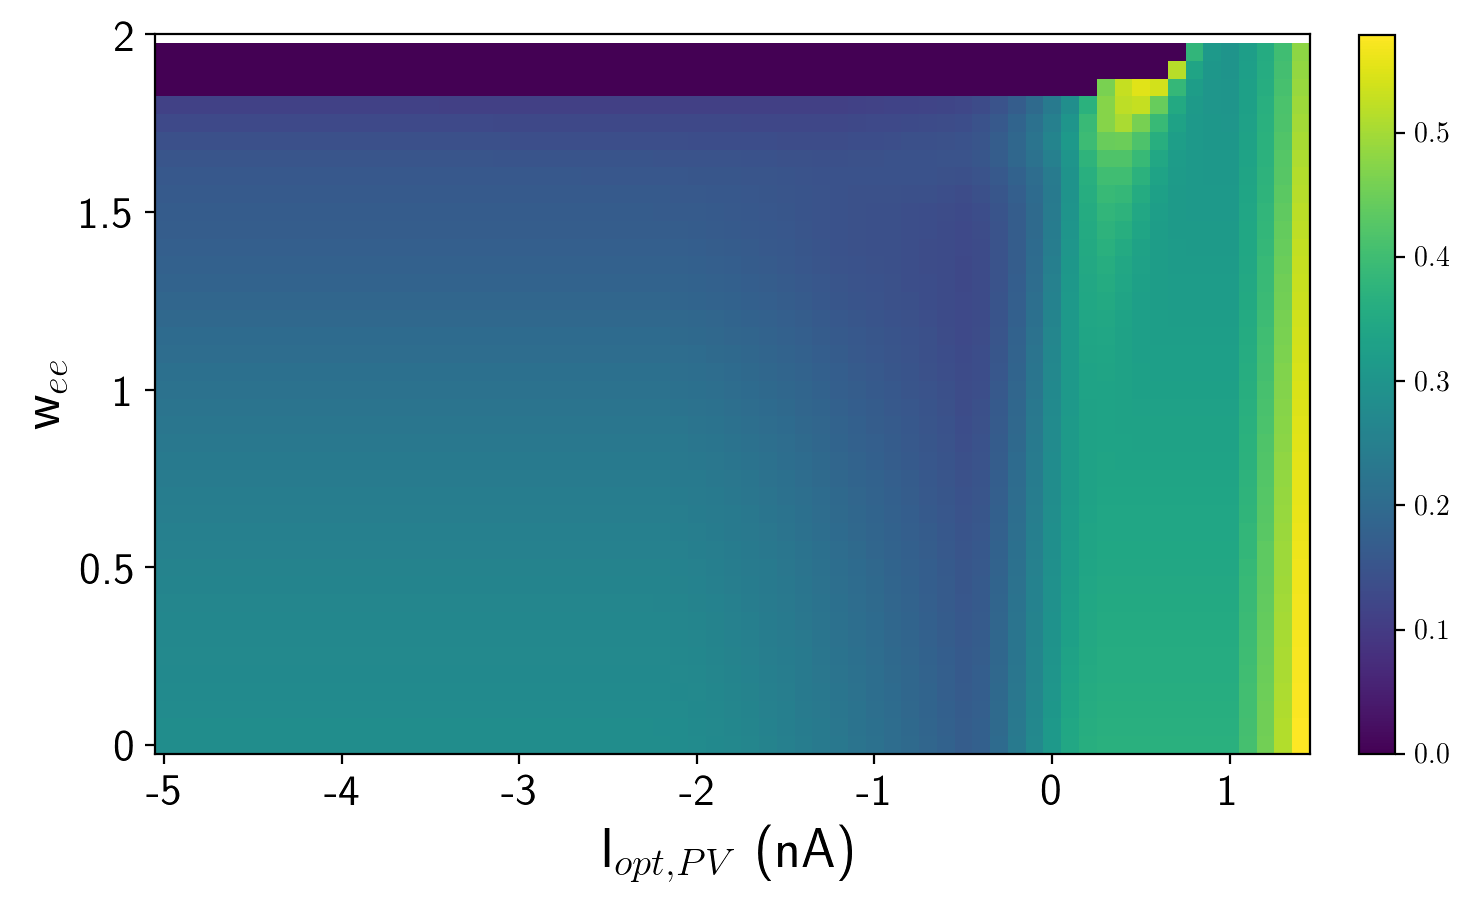

In [ ]:
# load precomputed data 
csi = np.load('Fig5-A-data.npy')

plt.rcParams['text.usetex'] = True

ticksx = [0, 10, 20, 30, 40, 50, 60]
labelsx = ['-5', '-4', '-3', '-2', '-1', '0', '1']

ticksy = [0, 10, 20, 30, 40]
labelsy = ['0', '0.5', '1', '1.5', '2']

#w_ees = np.arange(0,2,step=.05)
#opt_pv_vals = np.arange(-5,1.5,step=.1)

fig, ax = plt.subplots(1,1,figsize=(8,10),dpi=200)
c1 = ax.imshow(csi,cmap ='viridis', interpolation ='nearest', origin ='lower')
fig.colorbar(c1,fraction=0.029, pad=0.04);
ax.set_xlabel(r'I$_{opt,PV}$ (nA)',fontsize=20)
ax.set_ylabel(r'w$_{ee}$',fontsize=20)
ax.set_xticks(ticksx)
ax.set_yticks(ticksy)
ax.set_xticklabels(labelsx, fontsize=16)
ax.set_yticklabels(labelsy, fontsize=16)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig5-A.png', dpi=200,bbox_inches = "tight")
files.download('Fig5-A.png')

plt.show()

# Simulations for Figure 5 B




In [ ]:
w_ees = np.arange(0,2,step=.05) #.05
opt_sst_vals = np.arange(-3.,1.,step=.0625) #.0625
print(len(w_ees))
print(len(opt_sst_vals))

csi = np.zeros((len(w_ees),len(opt_sst_vals)))

for i,w in enumerate(w_ees):
  print(i)
  for j,o in enumerate(opt_sst_vals):
    #print(j)
    w_ee = w
    #SST Off
    opt_sst = I_opto(t,laser_on_times,val=o)
    opt_pv = np.zeros((len(t)))
    opt_gen_flag = 1
    sst_g,sst_u,sst_p,sst_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
    sst_g_flipped,sst_u_flipped,sst_p_flipped,sst_s_flipped = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext_flipped,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

    max = find_max([sst_u[1]],input_tones,dt,200)
    max_flipped = find_max([sst_u_flipped[1]],input_tones,dt,200)
    d1 = max[0][4]
    d2 = max_flipped[0][4]
    s1 = max[0][7]
    s2 = max_flipped[0][7]
    csi[i,j] = (d1+d2-s1-s2)/(d1+d2+s1+s2)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
np.save('Fig5-B-data.npy', csi)
files.download('Fig5-B-data.npy')


40
64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

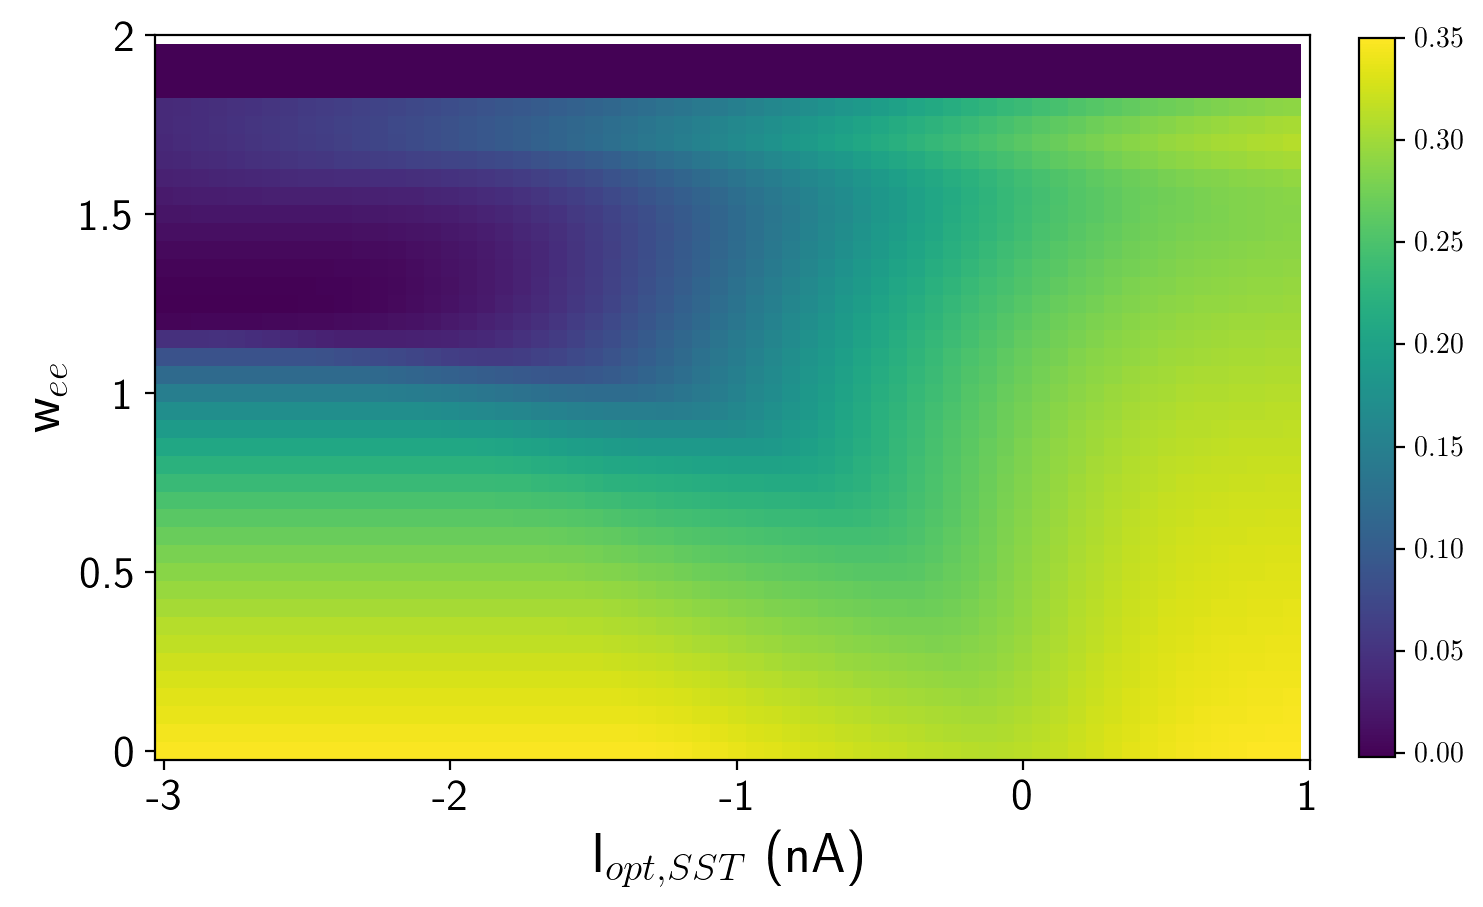

In [ ]:
# load precomputed data 
csi = np.load('Fig5-B-data.npy')

plt.rcParams['text.usetex'] = True

ticksx = [0, 16, 32, 48, 64]
labelsx = ['-3', '-2','-1','0','1']

ticksy = [0, 10, 20, 30, 40]
labelsy = ['0', '0.5', '1', '1.5', '2']

fig, ax = plt.subplots(1,1,figsize=(8,10),dpi=200)
c1 = ax.imshow(csi,cmap ='viridis', interpolation ='nearest', origin ='lower')
fig.colorbar(c1,fraction=0.029, pad=0.04);
ax.set_xlabel(r'I$_{opt,SST}$ (nA)',fontsize=20)
ax.set_ylabel(r'w$_{ee}$',fontsize=20)
ax.set_xticks(ticksx)
ax.set_yticks(ticksy)
ax.set_xticklabels(labelsx, fontsize=16)
ax.set_yticklabels(labelsy, fontsize=16)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig5-B.png', dpi=200,bbox_inches = "tight")
files.download('Fig5-B.png')

plt.show()

# Simulations for Figure 5C

In [ ]:
tau_ds = np.arange(1000,3000,step=50) #50
opt_pv_vals = np.arange(-5,1.5,step=.1)#.1
print(len(tau_ds))
print(len(opt_pv_vals))

csi = np.zeros((len(tau_ds),len(opt_pv_vals)))

for i,tau in enumerate(tau_ds):
  print(i)
  for j,o in enumerate(opt_pv_vals):
    #print(j)
    tau_d1 = tau
    #PV Off
    opt_pv = I_opto(t,laser_on_times,val=o)
    opt_sst = np.zeros((len(t)))
    opt_gen_flag = 1
    pv_g,pv_u,pv_p,pv_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
    pv_g_flipped,pv_u_flipped,pv_p_flipped,pv_s_flipped = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext_flipped,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

    max = find_max([pv_u[1]],input_tones,dt,200)
    max_flipped = find_max([pv_u_flipped[1]],input_tones,dt,200)
    d1 = max[0][4]
    d2 = max_flipped[0][4]
    s1 = max[0][7]
    s2 = max_flipped[0][7]
    csi[i,j] = (d1+d2-s1-s2)/(d1+d2+s1+s2)
  
np.save('Fig5-C-data.npy', csi)
files.download('Fig5-C-data.npy')

40
65
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

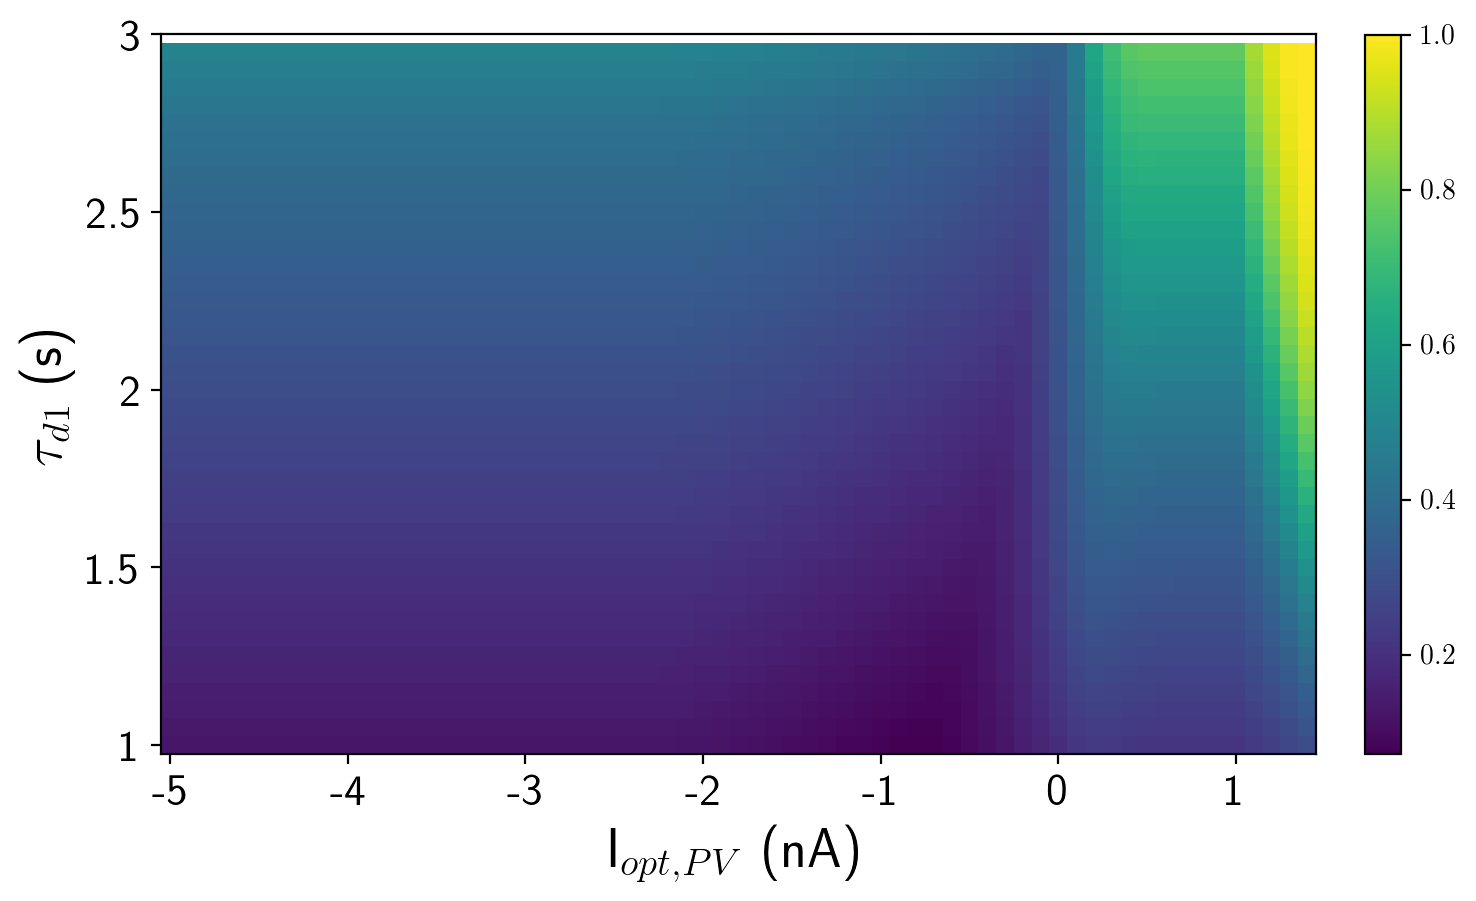

In [ ]:
# load precomputed data 
csi = np.load('Fig5-C-data.npy')

plt.rcParams['text.usetex'] = True

ticksx = [0, 10, 20, 30, 40, 50, 60]
labelsx = ['-5', '-4', '-3', '-2', '-1', '0', '1']

ticksy = [0, 10, 20, 30, 40]
labelsy = ['1', '1.5', '2', '2.5', '3']

fig, ax = plt.subplots(1,1,figsize=(8,10),dpi=200)
c1 = ax.imshow(csi,cmap ='viridis', interpolation ='nearest', origin ='lower')
fig.colorbar(c1,fraction=0.029, pad=0.04);
ax.set_xlabel(r'I$_{opt,PV}$ (nA)',fontsize=20)
ax.set_ylabel(r'$\tau_{d1}$ (s)',fontsize=20)
ax.set_xticks(ticksx)
ax.set_yticks(ticksy)
ax.set_xticklabels(labelsx, fontsize=16)
ax.set_yticklabels(labelsy, fontsize=16)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig5-C.png', dpi=200,bbox_inches = "tight")
files.download('Fig5-C.png')

plt.show()

# Simulations for Figure 5D

In [ ]:
tau_ds = np.arange(1000,3000,step=50) #50
opt_sst_vals = np.arange(-3.,1.,step=.0625) #.0625
print(len(tau_ds))
print(len(opt_sst_vals))

csi = np.zeros((len(tau_ds),len(opt_sst_vals)))

for i,tau in enumerate(tau_ds):
  print(i)
  for j,o in enumerate(opt_sst_vals):
    #print(j)
    tau_d1 = tau
    #SST Off
    opt_sst = I_opto(t,laser_on_times,val=o)
    opt_pv = np.zeros((len(t)))
    opt_gen_flag = 1
    sst_g,sst_u,sst_p,sst_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)
    sst_g_flipped,sst_u_flipped,sst_p_flipped,sst_s_flipped = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext_flipped,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

    max = find_max([sst_u[1]],input_tones,dt,200)
    max_flipped = find_max([sst_u_flipped[1]],input_tones,dt,200)
    d1 = max[0][4]
    d2 = max_flipped[0][4]
    s1 = max[0][7]
    s2 = max_flipped[0][7]
    csi[i,j] = (d1+d2-s1-s2)/(d1+d2+s1+s2)
np.save('Fig5-D-data.npy', csi)
files.download('Fig5-D-data.npy')

40
64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

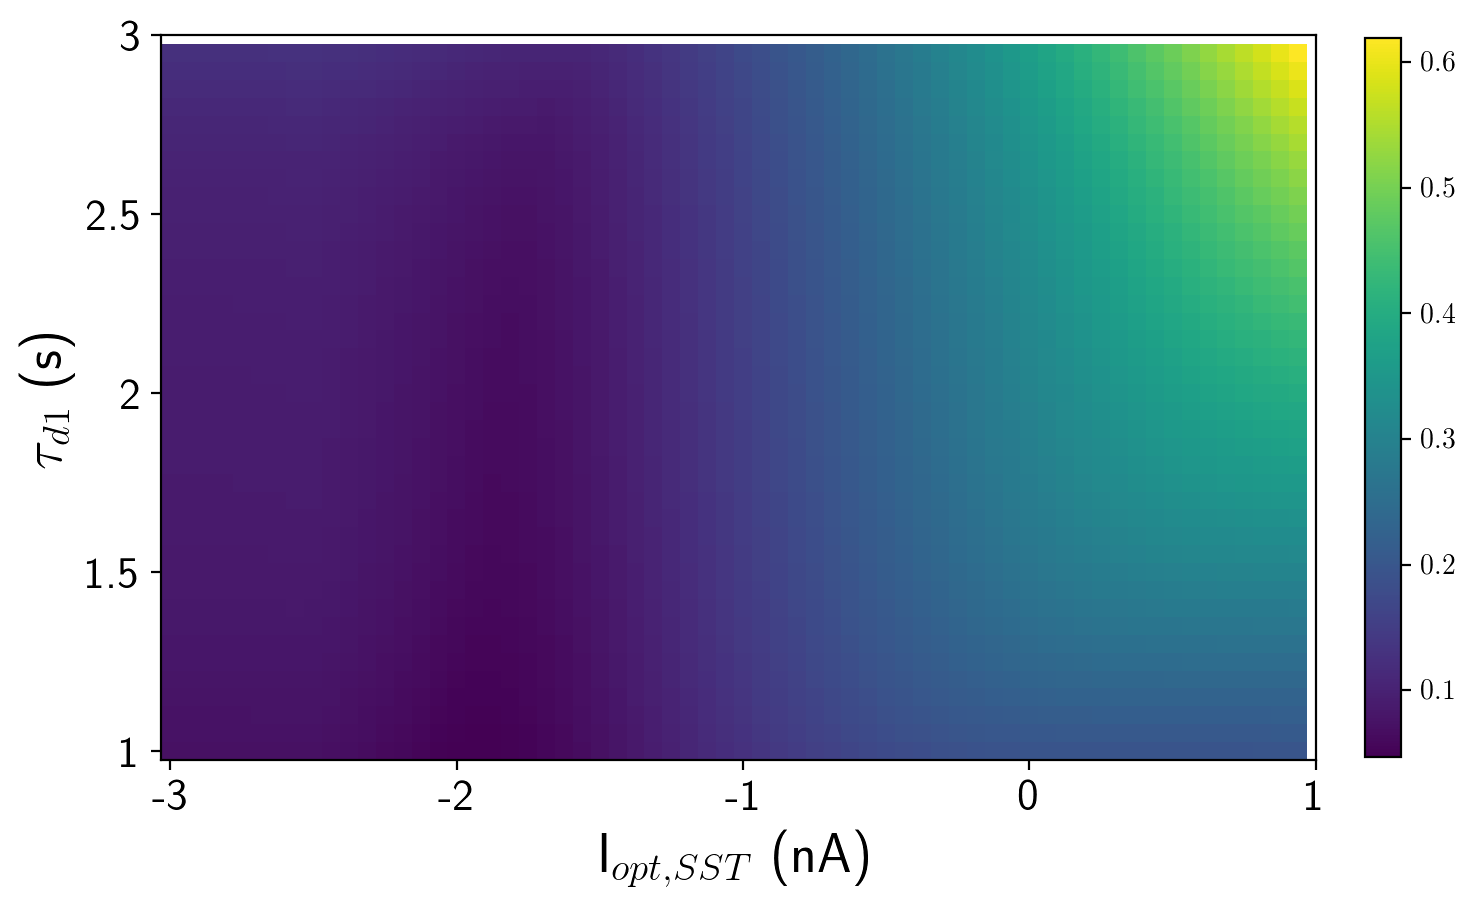

In [ ]:
# load precomputed data 
csi = np.load('Fig5-D-data.npy')

plt.rcParams['text.usetex'] = True

ticksx = [0, 16, 32, 48, 64]
labelsx = ['-3', '-2','-1','0','1']

ticksy = [0, 10, 20, 30, 40]
labelsy = ['1', '1.5', '2', '2.5', '3']

fig, ax = plt.subplots(1,1,figsize=(8,10),dpi=200)
c1 = ax.imshow(csi,cmap ='viridis', interpolation ='nearest', origin ='lower')
fig.colorbar(c1,fraction=0.029, pad=0.04);
ax.set_xlabel(r'I$_{opt,SST}$ (nA)',fontsize=20)
ax.set_ylabel(r'$\tau_{d1}$ (s)',fontsize=20)
ax.set_xticks(ticksx)
ax.set_yticks(ticksy)
ax.set_xticklabels(labelsx, fontsize=16)
ax.set_yticklabels(labelsy, fontsize=16)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig5-D.png', dpi=200,bbox_inches = "tight")
files.download('Fig5-D.png')

plt.show()